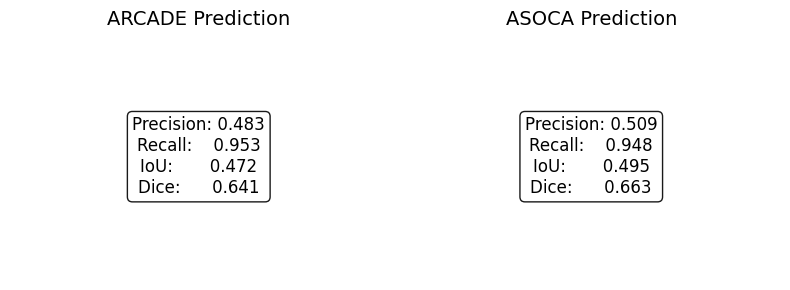

/Users/bundeli/opt/anaconda3/envs/cardiac_segmentation/lib/python3.11/contextlib.py:137: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  return next(self.gen)
/Users/bundeli/opt/anaconda3/envs/cardiac_segmentation/lib/python3.11/site-packages/napari/_qt/qt_event_loop.py:338: FutureWarning: `QApplication` instance access through `get_app` is deprecated and will be removed in 0.6.0.
Please use `get_qapp` instead.

  app = get_app()


2025-04-18 17:06:51.120 python[51969:12320885] _TIPropertyValueIsValid called with 16 on nil context!
2025-04-18 17:06:51.120 python[51969:12320885] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-04-18 17:06:51.121 python[51969:12320885] Text input context does not respond to _valueForTIProperty:
2025-04-18 17:12:25.415 python[51969:12320885] _TIPropertyValueIsValid called with 16 on nil context!
2025-04-18 17:12:25.415 python[51969:12320885] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-04-18 17:12:25.415 python[51969:12320885] Text input context does not respond to _valueForTIProperty:
2025-04-19 19:43:46.577 python[51969:12320885] _TIPropertyValueIsValid called with 16 on nil context!
2025-04-19 19:43:46.578 python[51969:12320885] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-04-19 19:43:46.578 python[51969:12320885] Text input context does not res

In [ ]:
import nrrd
import numpy as np
import napari
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from sklearn.metrics import precision_score, recall_score

# --- File paths ---
img_path = "/Users/bundeli/Documents/HSLU/FS25/BAA/StenUNet/pred_comparison/sten_0025_0000.nrrd"
arcade_path = "/Users/bundeli/Documents/HSLU/FS25/BAA/StenUNet/pred_comparison/sten_0025_arcade.nrrd"
asoca_path = "/Users/bundeli/Documents/HSLU/FS25/BAA/StenUNet/pred_comparison/sten_0025_asoca.nrrd"
gt_path = "/Users/bundeli/Documents/HSLU/FS25/BAA/StenUNet/pred_comparison/sten_0025_gt.nrrd"

# --- Load volumes ---
img, _ = nrrd.read(img_path)
arcade_pred, _ = nrrd.read(arcade_path)
asoca_pred, _ = nrrd.read(asoca_path)
gt, _ = nrrd.read(gt_path)

# --- Binarize predictions and GT ---
arcade_bin = (arcade_pred > 0).astype(np.uint8)
asoca_bin = (asoca_pred > 0).astype(np.uint8)
gt_bin = (gt > 0).astype(np.uint8)

# --- Normalize image for visualization ---
img_rescaled = rescale_intensity(img.astype(np.float32), in_range='image', out_range=(0, 1))

# --- Metric computation ---
def compute_metrics(gt, pred):
    intersection = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    dice = (2 * intersection) / (gt.sum() + pred.sum()) if (gt.sum() + pred.sum()) != 0 else 0.0
    iou = intersection / union if union != 0 else 0.0
    precision = precision_score(gt.flatten(), pred.flatten(), zero_division=0)
    recall = recall_score(gt.flatten(), pred.flatten(), zero_division=0)
    return precision, recall, iou, dice

metrics_arcade = compute_metrics(gt_bin, arcade_bin)
metrics_asoca = compute_metrics(gt_bin, asoca_bin)

# --- Plot side-by-side metrics ---
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
titles = ["ARCADE Prediction", "ASOCA Prediction"]
metrics_all = [metrics_arcade, metrics_asoca]

for ax, title, metrics in zip(axes, titles, metrics_all):
    precision, recall, iou, dice = metrics
    text = (
        f"Precision: {precision:.3f}\n"
        f"Recall:    {recall:.3f}\n"
        f"IoU:       {iou:.3f}\n"
        f"Dice:      {dice:.3f}"
    )
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9), transform=ax.transAxes)
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

# --- Napari Viewer ---
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3, title="Model Prediction Comparison")
    viewer.add_image(img_rescaled, name='CCTA Image', colormap='gray', rendering='attenuated_mip', opacity=0.9)
    viewer.add_labels(gt_bin, name='Ground Truth', opacity=0.4)
    viewer.add_labels(arcade_bin, name='ARCADE Prediction', opacity=0.5)
    viewer.add_labels(asoca_bin, name='ASOCA Prediction', opacity=0.5)
